In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

%matplotlib inline

In [20]:
# 参数设置
T = 20                   # 总时间 (μs)
N = 500                   # 时间步数
times = np.linspace(0, T, N)
omega = 2 * np.pi * 0.5   # 自由演化频率 (0.5 MHz)
delta_omega_std = 0.2     # 准静态噪声标准差 (MHz)
num_realizations = 500     # 噪声实现次数
gamma_phi = 0.01         # 退相干
# 初始态为叠加态 (|0> + |1>)/√2
psi0 = (basis(2, 0) + basis(2, 1)).unit()

In [ ]:
# 含噪声的自由演化哈密顿量
def noisy_hamiltonian(delta_omega):
    return 0.5 * (omega + delta_omega) * sigmaz()
c_ops_lindblad = [np.sqrt(gamma_phi) * sigmaz()]
# 自旋回波控制（T/2时刻施加π_x脉冲）
def add_echo_control():
    # print([[0.5 * (omega + delta_omega)*sigmaz(), lambda t, args: 1 if t < T/2 else -1]])
    return [[0.5 * (omega + delta_omega)*sigmaz(), lambda t, args: 1 if t < T/2 else -1]]

# 模拟单次噪声实现
def simulate_single(delta_omega, apply_echo=False):
    H = noisy_hamiltonian(delta_omega) if not apply_echo else add_echo_control()
    result = mesolve(
        H, psi0, times,
        c_ops=[],  # 额外退相干
        e_ops=[sigmax(), sigmay()],
        options=Options(store_states=False)
    )
    return result.expect[0], result.expect[1]  # 返回⟨σx⟩和⟨σy⟩

In [22]:
# 多次噪声实现取平均
avg_sx_no_echo, avg_sy_no_echo = np.zeros(N), np.zeros(N)
avg_sx_echo, avg_sy_echo = np.zeros(N), np.zeros(N)

for _ in range(num_realizations):
    delta_omega = np.random.normal(0, delta_omega_std)
    
    # 无自旋回波
    sx, sy = simulate_single(delta_omega, apply_echo=False)
    avg_sx_no_echo += sx
    avg_sy_no_echo += sy
    
    # 有自旋回波
    sx_echo, sy_echo = simulate_single(delta_omega, apply_echo=True)
    avg_sx_echo += sx_echo
    avg_sy_echo += sy_echo

# 归一化
avg_sx_no_echo /= num_realizations
avg_sy_no_echo /= num_realizations
avg_sx_echo /= num_realizations
avg_sy_echo /= num_realizations

[[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.59732651  0.        ]
 [ 0.         -1.59732651]], <function add_echo_control.<locals>.<lambda> at 0x00000196D6EDADD0>]]
[[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.44288038  0.        ]
 [ 0.         -1.44288038]], <function add_echo_control.<locals>.<lambda> at 0x0000019696B108B0>]]
[[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.65451624  0.        ]
 [ 0.         -1.65451624]], <function add_echo_control.<locals>.<lambda> at 0x0000019696B10790>]]
[[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.54431349  0.        ]
 [ 0.         -1.54431349]], <function add_echo_control.<locals>.<lambda> at 0x00000196D73460E0>]]
[[Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.450696

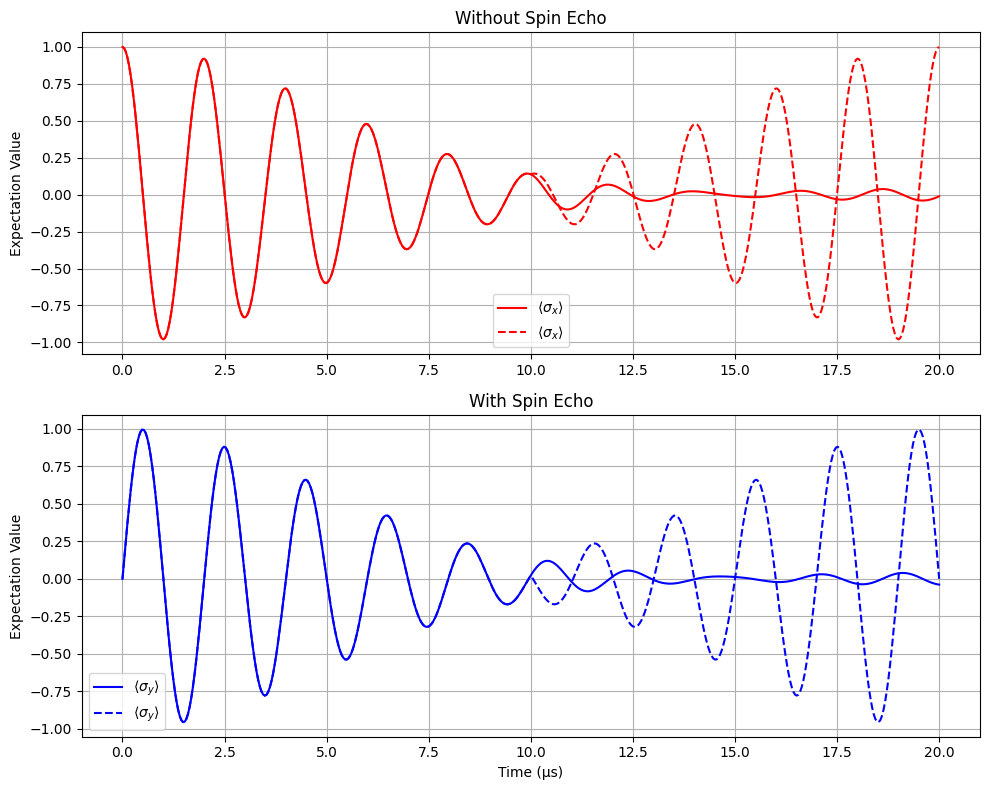

In [23]:
# 绘制结果
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# 无自旋回波
axes[0].plot(times, avg_sx_no_echo, 'r', label='$\\langle \\sigma_x \\rangle$')
# 有自旋回波
axes[0].plot(times, avg_sx_echo, 'r--', label='$\\langle \\sigma_x \\rangle$')
axes[0].set_title('Without Spin Echo')
axes[0].set_ylabel('Expectation Value')
axes[0].grid(True)
axes[0].legend()


axes[1].plot(times, avg_sy_no_echo, 'b', label='$\\langle \\sigma_y \\rangle$')
axes[1].plot(times, avg_sy_echo, 'b--', label='$\\langle \\sigma_y \\rangle$')
axes[1].set_title('With Spin Echo')
axes[1].set_xlabel('Time (μs)')
axes[1].set_ylabel('Expectation Value')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

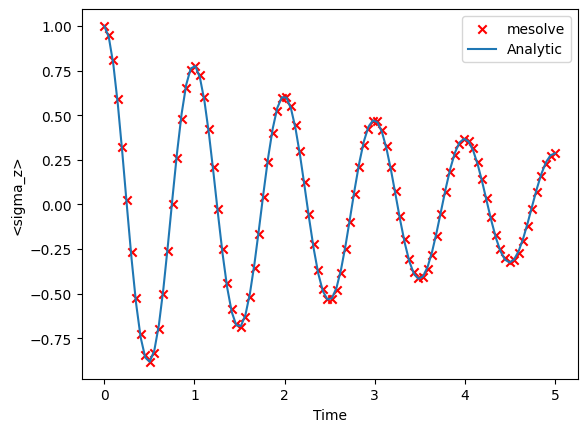

In [5]:
plt.scatter(tlist, res.expect[0], c="r", marker="x", label="mesolve")
plt.plot(tlist, sz_analytic, label="Analytic")
plt.xlabel("Time"), plt.ylabel("<sigma_z>")
plt.legend();